In [2]:
%matplotlib inline

Analyze Visium H&E data
=======================

This tutorial shows how to apply Squidpy for the analysis of Visium spatial transcriptomics data.

The dataset used here consists of a Visium slide of a coronal section of the mouse brain.
The original dataset is publicly available at the
10x Genomics `dataset portal <https://support.10xgenomics.com/spatial-gene-expression/datasets>`_ .
Here, we provide a pre-processed dataset, with pre-annotated clusters, in AnnData format and the
tissue image in {class}`squidpy.im.ImageContainer` format.

A couple of notes on pre-processing:

    - The pre-processing pipeline is the same as the one shown in the original
      `Scanpy tutorial <https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html>`_ .
    - The cluster annotation was performed using several resources, such as the
      `Allen Brain Atlas <https://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas>`_ ,
      the `Mouse Brain gene expression atlas <http://mousebrain.org/>`_ from
      the Linnarson lab and this recent `pre-print <https://www.biorxiv.org/content/10.1101/2020.07.24.219758v1>`_ .

Import packages & data
----------------------
To run the notebook locally, create a conda environment as *conda env create -f environment.yml* using this
`environment.yml <https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml>`_.

In [3]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7
squidpy==1.2.3


100%|██████████| 314M/314M [00:45<00:00, 7.19MB/s] 


First, let's visualize cluster annotation in spatial context
with {func}`squidpy.pl.spatial_scatter`.

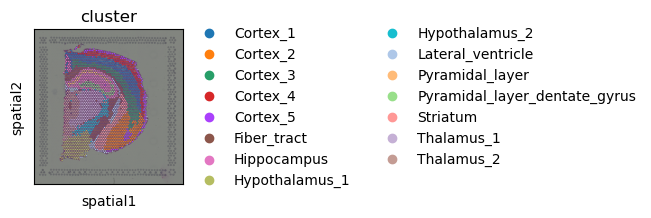

In [4]:
sq.pl.spatial_scatter(adata, color="cluster")

Image features
--------------
Visium datasets contain high-resolution images of the tissue that was used for the gene extraction.
Using the function {func}`squidpy.im.calculate_image_features` you can calculate image features
for each Visium spot and create a ``obs x features`` matrix in ``adata`` that can then be analyzed together
with the ``obs x gene`` gene expression matrix.

By extracting image features we are aiming to get both similar and complementary information to the
gene expression values.
Similar information is for example present in the case of a tissue with two different cell types
whose morphology is different.
Such cell type information is then contained in both the gene expression values and the tissue image features.

Squidpy contains several feature extractors and a flexible pipeline of calculating features
of different scales and sizes.
There are several detailed examples of how to use {func}`squidpy.im.calculate_image_features`.
{doc}`../examples/image/compute_features` provides a good starting point for learning more.

Here, we will extract `summary` features at different crop sizes and scales to allow
the calculation of multi-scale features and `segmentation` features.
For more information on the summary features,
also refer to {doc}`../examples/image/compute_summary_features`.

In [5]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

100%|██████████| 2688/2688 [00:24<00:00, 109.66/s]


We can use the extracted image features to compute a new cluster annotation.
This could be useful to gain insights in similarities across spots based on image morphology.

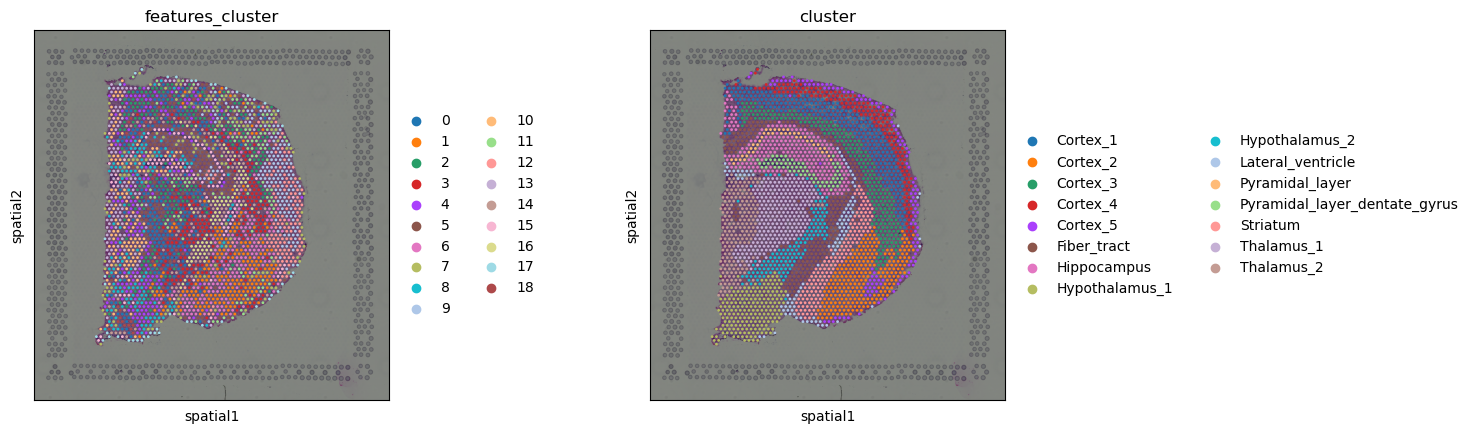

In [6]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "cluster"])

Comparing gene and feature clusters, we notice that in some regions,
they look very similar, like the cluster *Fiber_tract*, or clusters around the Hippocampus
seems to be roughly recapitulated by the clusters in image feature space.
In others, the feature clusters look different, like in the cortex,
where the gene clusters show the layered structure of the cortex,
and the features clusters rather seem to show different regions of the cortex.

This is only a simple, comparative analysis of the image features,
note that you could also use the image features to e.g. compute a common image and gene clustering
by computing a shared neighbors graph (for instance on concatenated PCAs on both feature spaces).

Spatial statistics and graph analysis
-------------------------------------
Similar to other spatial data, we can investigate spatial organization
by leveraging spatial and graph statistics in Visium data.

Neighborhood enrichment
+++++++++++++++++++++++
Computing a neighborhood enrichment can help us identify spots clusters that share
a common neighborhood structure across the tissue.
We can compute such score with the following function: {func}`squidpy.gr.nhood_enrichment`.
In short, it's an enrichment score on spatial proximity of clusters:
if spots belonging to two different clusters are often close to each other,
then they will have a high score and can be defined as being *enriched*.
On the other hand, if they are far apart, and therefore are seldom a neighborhood,
the score will be low and they can be defined as *depleted*. This score is
based on a permutation-based test, and you can set
the number of permutations with the ``n_perms`` argument (default is 1000).

Since the function works on a connectivity matrix, we need to compute that as well.
This can be done with {func}`squidpy.gr.spatial_neighbors`.
Please see {doc}`../examples/graph/compute_spatial_neighbors` for more details
of how this function works.

Finally, we'll directly visualize the results with {func}`squidpy.pl.nhood_enrichment`.

100%|██████████| 1000/1000 [00:06<00:00, 150.39/s]


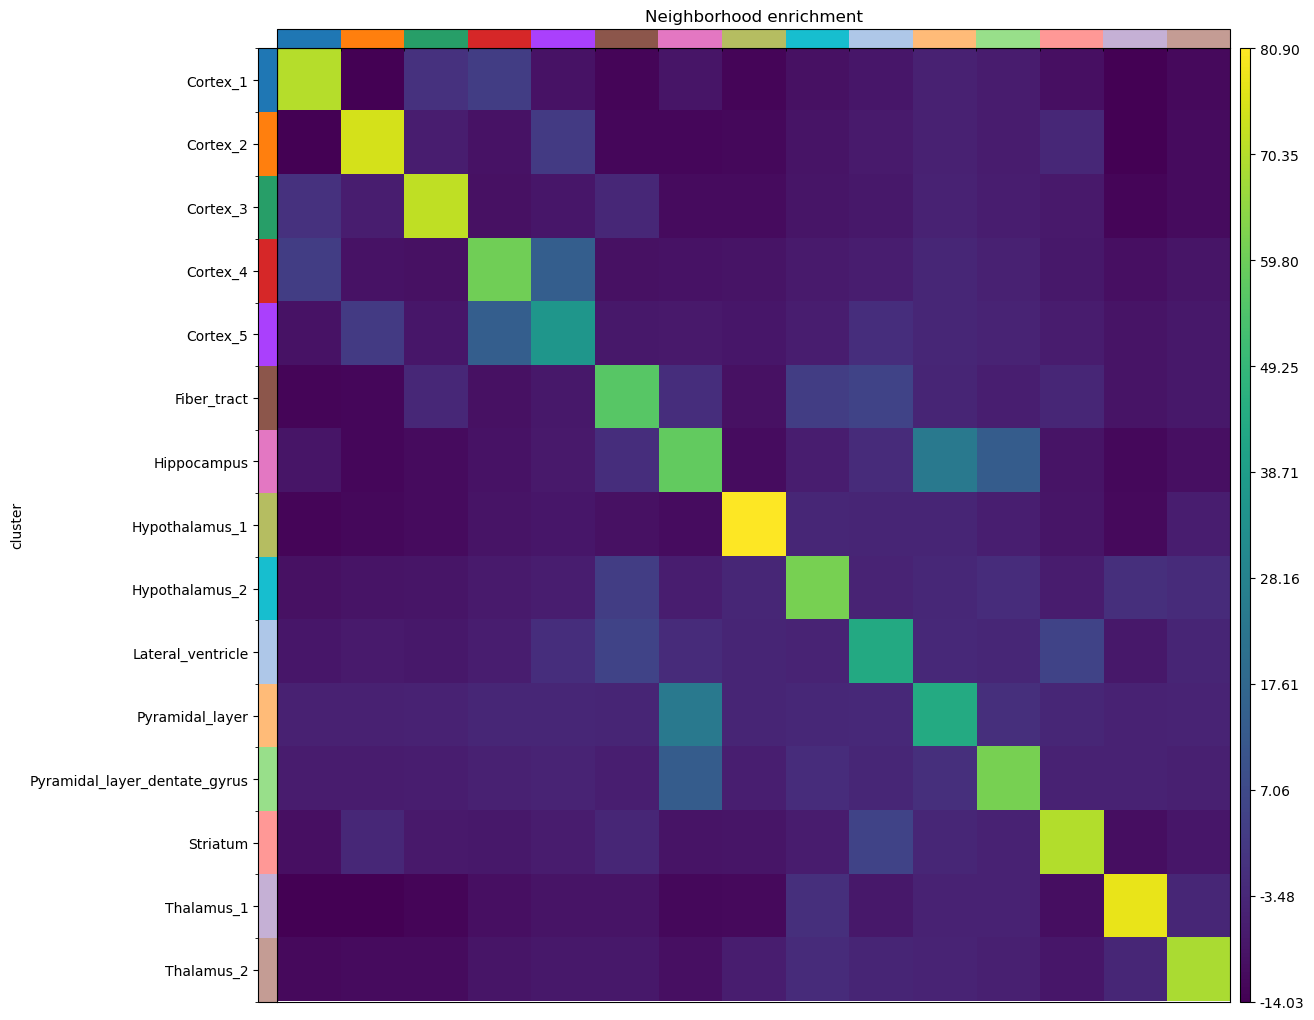

In [7]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Given the spatial organization of the mouse brain coronal section,
not surprisingly we find high neighborhood enrichment the Hippocampus region:
*Pyramidal_layer_dentate_gyrus* and *Pyramidal_layer* clusters seems
to be often neighbors with the larger *Hippocampus* cluster.

Co-occurrence across spatial dimensions
+++++++++++++++++++++++++++++++++++++++
In addition to the neighbor enrichment score, we can visualize cluster co-occurrence in spatial dimensions.
This is a similar analysis of the one presented above, yet it does not operate on the connectivity matrix,
but on the original spatial coordinates. The co-occurrence score is defined as:

.. math::
   \frac{p(exp|cond)}{p(exp)}

where {math}`p(exp|cond)` is the conditional probability of observing a cluster {math}`exp` conditioned
on the presence of a cluster {math}`cond`, whereas {math}`p(exp)` is the probability of observing {math}`exp`
in the radius size of interest.
The score is computed across increasing radii size around each observation (i.e. spots here) in the tissue.

We are gonna compute such score with {func}`squidpy.gr.co_occurrence` and set the cluster annotation
for the conditional probability with the argument ``clusters``.
Then, we visualize the results with {func}`squidpy.pl.co_occurrence`.

100%|██████████| 1/1 [00:07<00:00,  7.11s/]


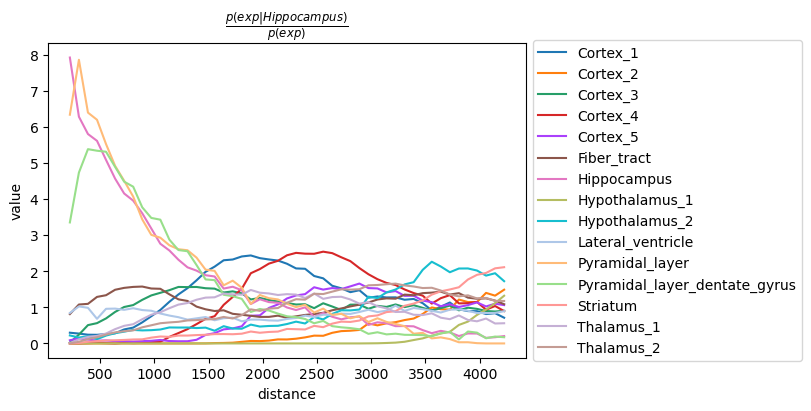

In [8]:
sq.gr.co_occurrence(adata, cluster_key="cluster")
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

The result largely recapitulates the previous analysis:
the *Pyramidal_layer* cluster seem to co-occur at short distances
with the larger *Hippocampus* cluster.
It should be noted that the distance units are given in pixels of
the Visium ``source_image``, and corresponds to the same unit of
the spatial coordinates saved in ``adata.obsm['spatial']``.

Ligand-receptor interaction analysis
++++++++++++++++++++++++++++++++++++
We are continuing the analysis showing couple of feature-level methods that are very relevant
for the analysis of spatial molecular data. For instance, after
quantification of cluster co-occurrence,
we might be interested in finding molecular instances
that could potentially drive cellular communication.
This naturally translates in a ligand-receptor interaction analysis.
In Squidpy, we provide a fast re-implementation the popular method CellPhoneDB {cite}`cellphonedb`
(`code <https://github.com/Teichlab/cellphonedb>`_ )
and extended its database of annotated ligand-receptor interaction pairs with
the popular database *Omnipath* {cite}`omnipath`.
You can run the analysis for all clusters pairs, and all genes (in seconds,
without leaving this notebook), with {func}`squidpy.gr.ligrec`.
Furthermore, we'll directly visualize the results, filtering out lowly-expressed genes
(with the ``means_range`` argument) and increasing the threshold for
the adjusted p-value (with the ``alpha`` argument).
We'll also subset the visualization for only one source group,
the *Hippocampus* cluster, and two target groups, *Pyramidal_layer_dentate_gyrus* and *Pyramidal_layer* cluster.

100%|██████████| 100/100 [00:16<00:00,  5.93permutation/s]


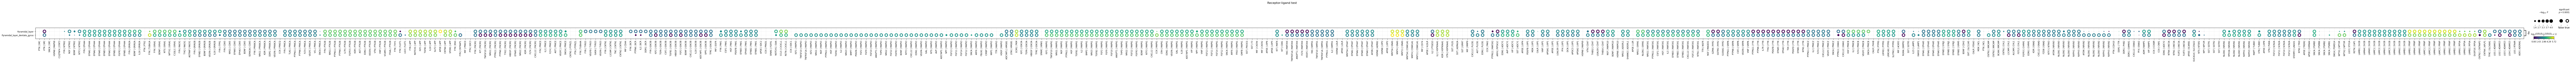

In [9]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="cluster",
)
sq.pl.ligrec(
    adata,
    cluster_key="cluster",
    source_groups="Hippocampus",
    target_groups=["Pyramidal_layer", "Pyramidal_layer_dentate_gyrus"],
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

The dotplot visualization provides an interesting set of candidate ligand-receptor
annotation that could be involved in cellular interactions in the Hippocampus.
A more refined analysis would be for instance to integrate these results with
the results of a deconvolution method, to understand what's the proportion of single-cell
cell types present in this region of the tissue.

Spatially variable genes with Moran's I
+++++++++++++++++++++++++++++++++++++++
Finally, we might be interested in finding genes that show spatial patterns.
There are several methods that aimed at address this explicitly,
based on point processes or Gaussian process regression framework:

  - *SPARK* - `paper <https://www.nature.com/articles/s41592-019-0701-7#Abs1>`__,
    `code <https://github.com/xzhoulab/SPARK>`__.
  - *Spatial DE*  - `paper <https://www.nature.com/articles/nmeth.4636>`__,
    `code <https://github.com/Teichlab/SpatialDE>`__.
  - *trendsceek* - `paper <https://www.nature.com/articles/nmeth.4634>`__,
    `code <https://github.com/edsgard/trendsceek>`__.
  - *HMRF* - `paper <https://www.nature.com/articles/nbt.4260>`__,
    `code <https://bitbucket.org/qzhudfci/smfishhmrf-py>`__.

Here, we provide a simple approach based on the well-known
`Moran's I statistics <https://en.wikipedia.org/wiki/Moran%27s_I>`_
which is in fact used also as a baseline method in the spatially variable gene papers listed above.
The function in Squidpy is called {func}`squidpy.gr.spatial_autocorr`, and
returns both test statistics and adjusted p-values in {attr}`anndata.AnnData.var` slot.
For time reasons, we will evaluate a subset of the highly variable genes only.

In [10]:
genes = adata[:, adata.var.highly_variable].var_names.values[:1000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

100%|██████████| 100/100 [00:47<00:00,  2.11/s]


The results are saved in ``adata.uns['moranI']`` slot.
Genes have already been sorted by Moran's I statistic.

In [11]:
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Olfm1,0.763291,0.0,0.000131,0.0,0.009901,0.000220,0.0,0.0,0.011648
Plp1,0.747660,0.0,0.000131,0.0,0.009901,0.000268,0.0,0.0,0.011648
Itpka,0.727076,0.0,0.000131,0.0,0.009901,0.000216,0.0,0.0,0.011648
Snap25,0.720987,0.0,0.000131,0.0,0.009901,0.000237,0.0,0.0,0.011648
Nnat,0.708637,0.0,0.000131,0.0,0.009901,0.000282,0.0,0.0,0.011648
Ppp3ca,0.693320,0.0,0.000131,0.0,0.009901,0.000232,0.0,0.0,0.011648
Chn1,0.684957,0.0,0.000131,0.0,0.009901,0.000281,0.0,0.0,0.011648
Mal,0.679775,0.0,0.000131,0.0,0.009901,0.000293,0.0,0.0,0.011648
Tmsb4x,0.676719,0.0,0.000131,0.0,0.009901,0.000246,0.0,0.0,0.011648
Cldn11,0.674110,0.0,0.000131,0.0,0.009901,0.000270,0.0,0.0,0.011648


We can select few genes and visualize their expression levels in the tissue with {func}`squidpy.pl.spatial_scatter`.

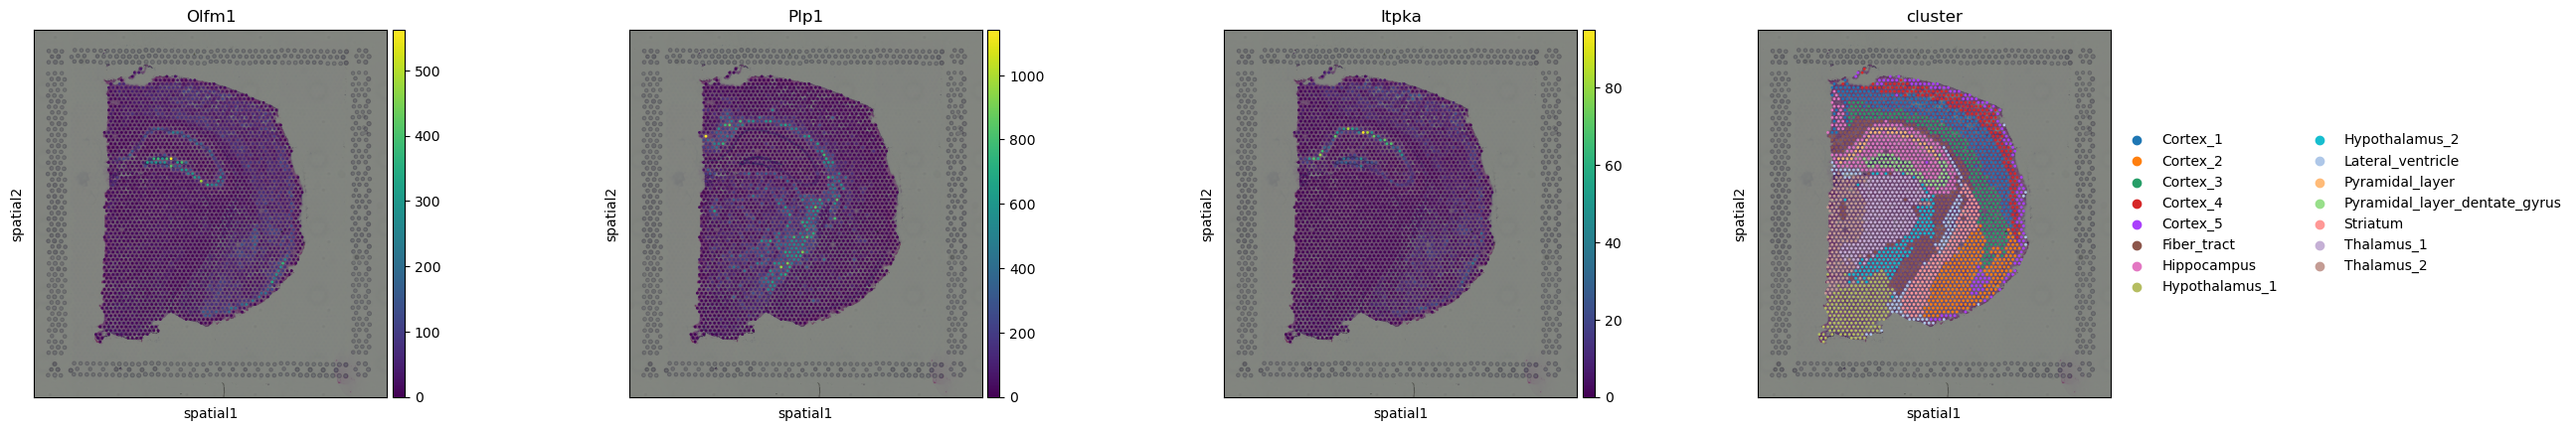

In [12]:
sq.pl.spatial_scatter(adata, color=["Olfm1", "Plp1", "Itpka", "cluster"])

Interestingly, some of these genes seems to be related to the *pyramidal* layers and the *fiber tract*.